             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   
5  2022-10-28 13:14:27     198.102.5.160        147.190.155.133        17430   
6  2022-05-16 17:55:43     97.253.103.59           77.16.101.53        26562   
7  2023-02-12 07:13:17      11.48.99.245         178.157.14.116        34489   
8  2023-06-27 11:02:56     49.32.208.167           72.202.237.9        56296   
9  2021-08-15 22:29:04   114.109.149.113         160.88.194.172        37918   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503    

/tmp/ipykernel_28588/2538494940.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax6 = sns.barplot(x=top_sources.values, y=top_sources.index, ax=axes[2, 1], palette="Reds_r")
/tmp/ipykernel_28588/2538494940.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax7 = sns.barplot(x=top_dest.values, y=top_dest.index, ax=axes[3, 0], palette="Blues_r")


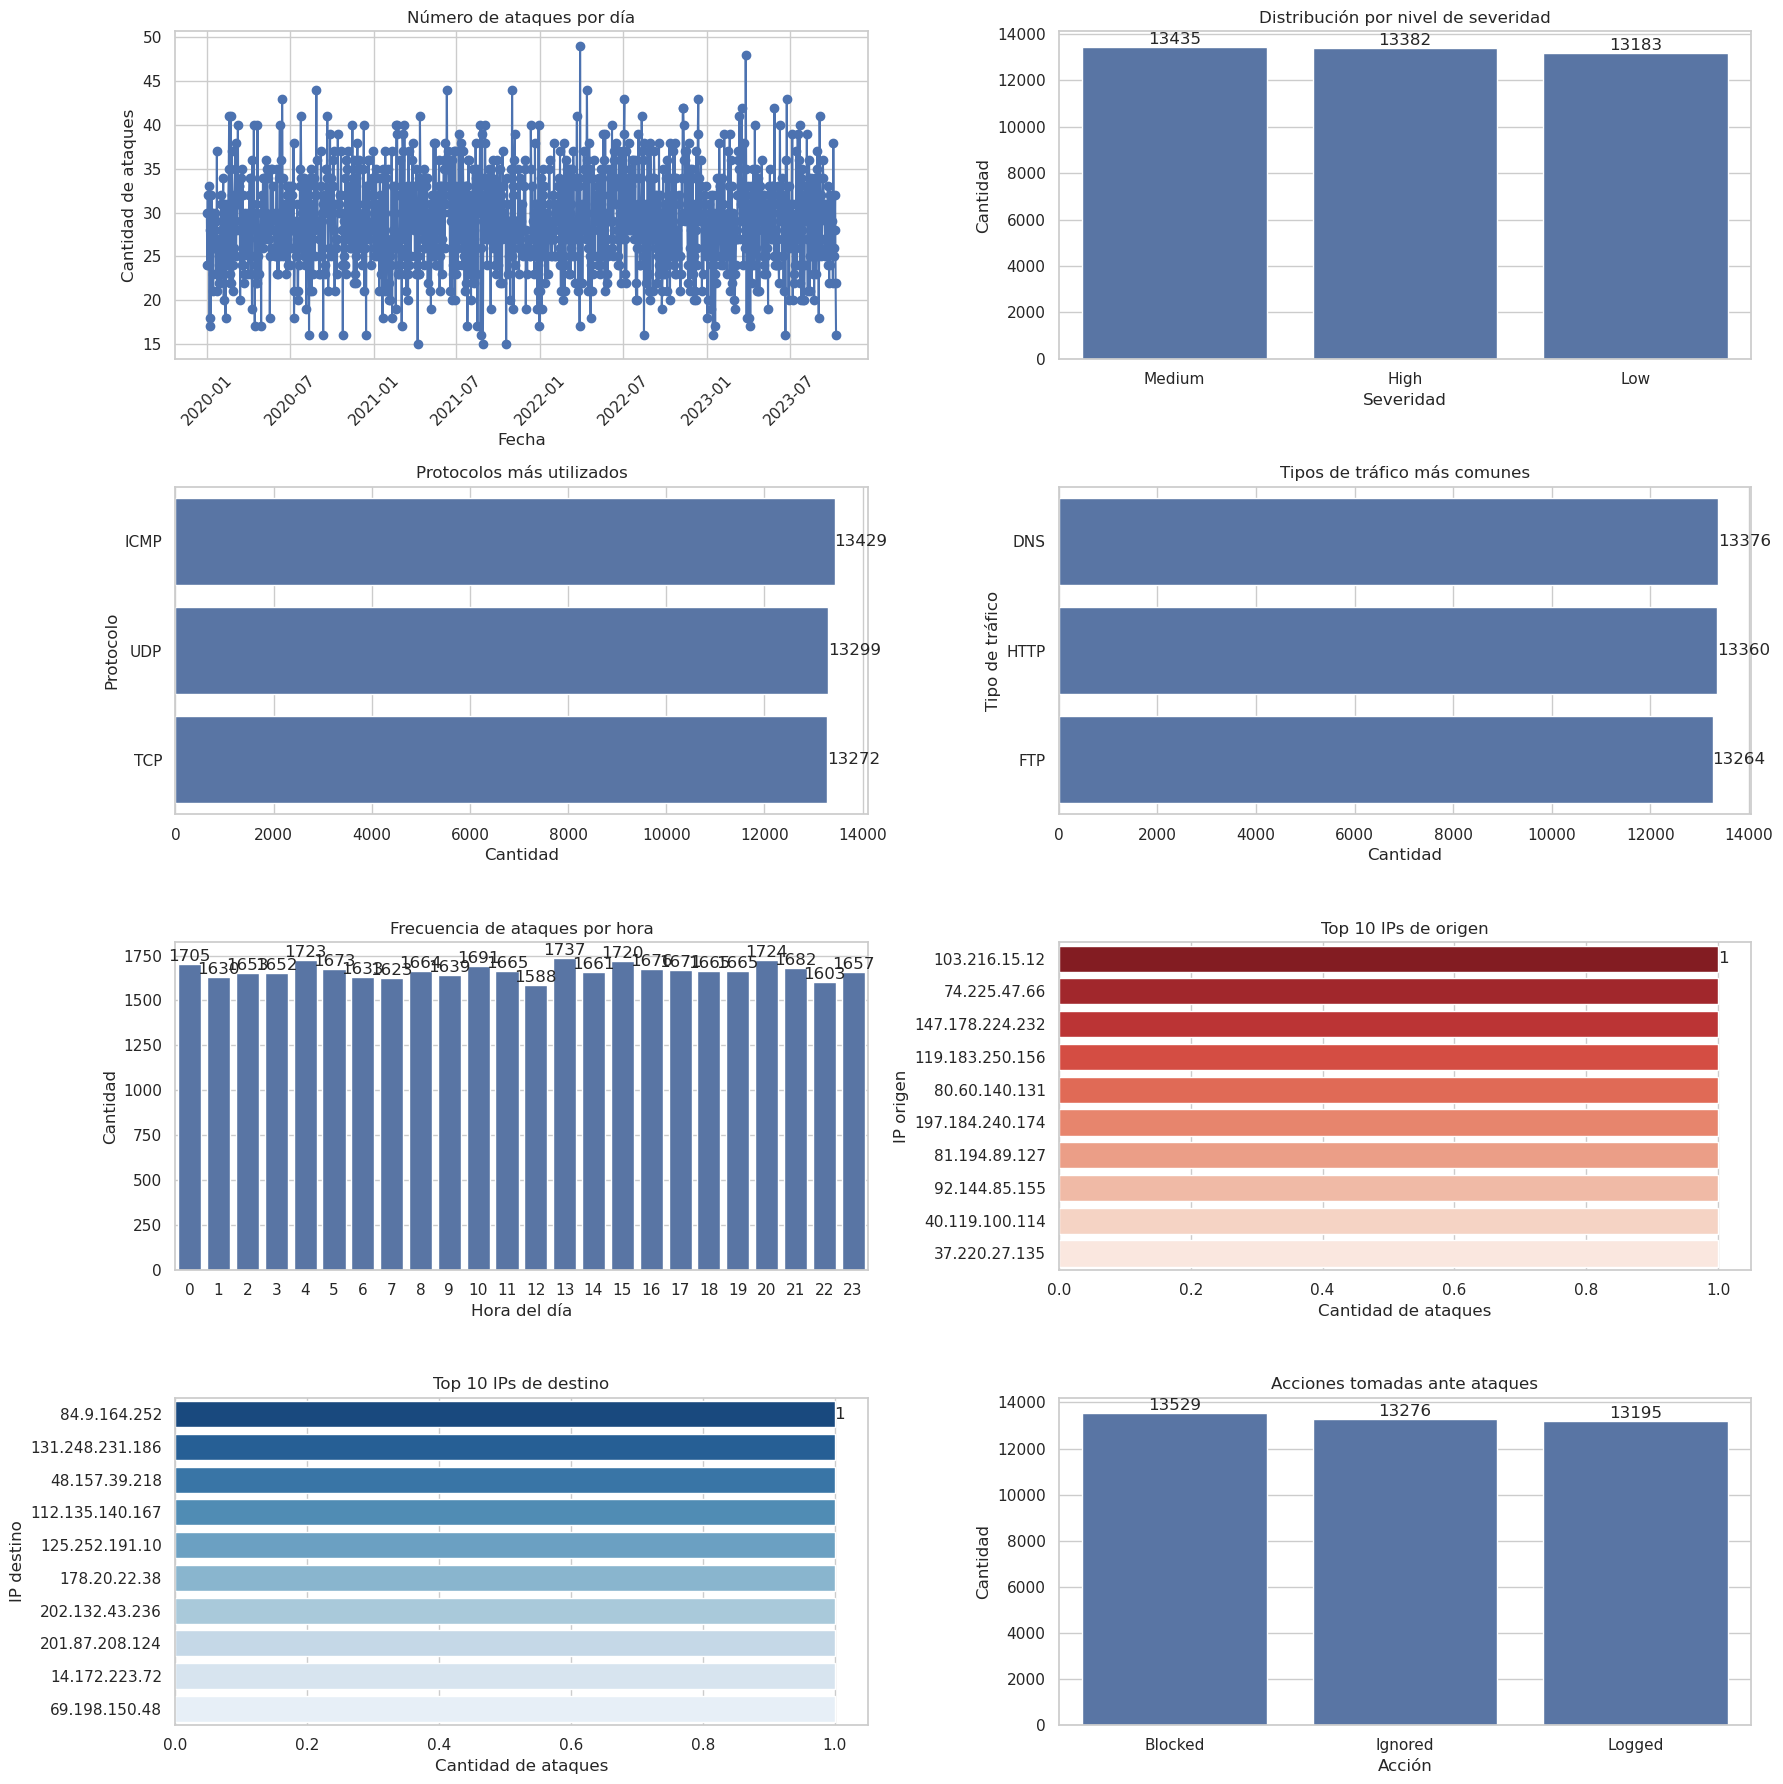

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import kagglehub  # Asegúrate de tener kagglehub instalado pip install kagglehub

# Descargar dataset desde Kaggle
path = kagglehub.dataset_download("teamincribo/cyber-security-attacks")

# Cargar archivo CSV (puedes ajustar el nombre si es diferente)
df = pd.read_csv(f"{path}/cybersecurity_attacks.csv")

#################################################################################
# Seleccionar solo algunas columnas y los primeros 10 registros

subset = df[['Timestamp', 'Source IP Address', 'Attack Type', 'Attack Signature']].head(10)

# Paso 2: Conectarse a PostgreSQL
conn = psycopg2.connect(
    database="cybersecurity_logs",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

# Paso 3: Crear la tabla si no existe
cursor.execute("""
    CREATE TABLE IF NOT EXISTS registros (
        id SERIAL PRIMARY KEY,
        timestamp TIMESTAMP NOT NULL,
        ip_address VARCHAR(50),
        tipo_evento VARCHAR(50),
        descripcion TEXT
    );
""")
conn.commit()

# Paso 4: Recorrer e insertar los registros uno por uno
for index, row in subset.iterrows():
    cursor.execute("""
        INSERT INTO registros (timestamp, ip_address, tipo_evento, descripcion)
        VALUES (%s, %s, %s, %s);
    """, (row['Timestamp'], row['Source IP Address'], row['Attack Type'], row['Attack Signature']))

conn.commit()
cursor.close()
conn.close()

print("✅ Tabla verificada/creada e inserción de los 10 registros completada.")

#################################################################################


# Normalizar columnas
df.columns = df.columns.str.strip()

# Convertir 'Timestamp' a datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Crear columna de hora para análisis por hora
df['Hour'] = df['Timestamp'].dt.hour

# Crear las gráficas
fig, axes = plt.subplots(4, 2, figsize=(18, 18))

# 1. Número de ataques por día
eventos_diarios = df.resample('D', on='Timestamp').size()
axes[0, 0].plot(eventos_diarios.index, eventos_diarios.values, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Número de ataques por día")
axes[0, 0].set_xlabel("Fecha")
axes[0, 0].set_ylabel("Cantidad de ataques")
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Distribución de niveles de severidad
ax2 = sns.countplot(x="Severity Level", data=df, order=df["Severity Level"].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title("Distribución por nivel de severidad")
axes[0, 1].set_xlabel("Severidad")
axes[0, 1].set_ylabel("Cantidad")
for container in ax2.containers:
    ax2.bar_label(container, fmt="%d")

# 3. Protocolos más utilizados
ax3 = sns.countplot(y="Protocol", data=df, order=df["Protocol"].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title("Protocolos más utilizados")
axes[1, 0].set_xlabel("Cantidad")
axes[1, 0].set_ylabel("Protocolo")
for container in ax3.containers:
    ax3.bar_label(container, fmt="%d")

# 4. Tipos de tráfico más comunes
ax4 = sns.countplot(y="Traffic Type", data=df, order=df["Traffic Type"].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title("Tipos de tráfico más comunes")
axes[1, 1].set_xlabel("Cantidad")
axes[1, 1].set_ylabel("Tipo de tráfico")
for container in ax4.containers:
    ax4.bar_label(container, fmt="%d")

# 5. Frecuencia por hora
ax5 = sns.countplot(x="Hour", data=df, ax=axes[2, 0])
axes[2, 0].set_title("Frecuencia de ataques por hora")
axes[2, 0].set_xlabel("Hora del día")
axes[2, 0].set_ylabel("Cantidad")
for container in ax5.containers:
    ax5.bar_label(container, fmt="%d")

# 6. IPs de origen con más ataques
top_sources = df["Source IP Address"].value_counts().nlargest(10)
ax6 = sns.barplot(x=top_sources.values, y=top_sources.index, ax=axes[2, 1], palette="Reds_r")
axes[2, 1].set_title("Top 10 IPs de origen")
axes[2, 1].set_xlabel("Cantidad de ataques")
axes[2, 1].set_ylabel("IP origen")
ax6.bar_label(ax6.containers[0], fmt="%d")

# 7. IPs de destino con más ataques
top_dest = df["Destination IP Address"].value_counts().nlargest(10)
ax7 = sns.barplot(x=top_dest.values, y=top_dest.index, ax=axes[3, 0], palette="Blues_r")
axes[3, 0].set_title("Top 10 IPs de destino")
axes[3, 0].set_xlabel("Cantidad de ataques")
axes[3, 0].set_ylabel("IP destino")
ax7.bar_label(ax7.containers[0], fmt="%d")

# 8. Acciones tomadas
ax8 = sns.countplot(x="Action Taken", data=df, order=df["Action Taken"].value_counts().index, ax=axes[3, 1])
axes[3, 1].set_title("Acciones tomadas ante ataques")
axes[3, 1].set_xlabel("Acción")
axes[3, 1].set_ylabel("Cantidad")
for container in ax8.containers:
    ax8.bar_label(container, fmt="%d")

plt.tight_layout()
plt.savefig('dashboard_cyberseguridad_kaggle.png')
plt.show()